In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-20m.zip
!unzip ml-20m.zip

--2023-06-12 17:37:13--  https://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M   121MB/s    in 1.6s    

2023-06-12 17:37:14 (121 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [2]:
pip install Bottleneck

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 7.7 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
from scipy import sparse
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
sn.set()
import pandas as pd
import tensorflow as tf
from tensorflow.keras.regularizers import L2
import bottleneck as bn
from copy import deepcopy

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

import scipy.stats as stats

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
raw_data = pd.read_csv('ml-20m/ratings.csv',header=0)
raw_data.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


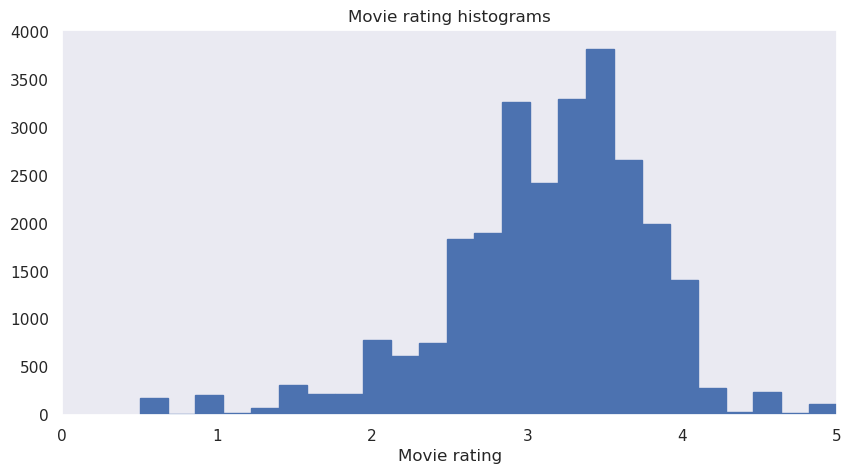

In [5]:
movies = pd.read_csv("ml-20m/movies.csv")
dftmp = raw_data[['movieId','rating']].groupby('movieId').mean()
rating_stats = []
dftmp.hist(bins=25, grid=False, edgecolor='b', label ='All genres', figsize=(10,5))
plt.xlim(0,5)
plt.xlabel('Movie rating')
plt.title('Movie rating histograms')
plt.show()


In [ ]:
raw_data = raw_data[raw_data['rating'] > 3.0]
raw_data.head()

In [6]:
min_uc = 5
min_sc = 0
n_heldout_users = 10000
output_dir = "/kaggle/working"
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count


def filter_triplets(tp, min_uc=min_uc, min_sc=min_sc): 
    if min_sc > 0:
        itemcount = get_count(tp, 'movieId')
        tp = tp[tp['movieId'].isin(itemcount[itemcount >= min_sc].movieId)]
    
    if min_uc > 0:
        usercount = get_count(tp, 'userId')
        tp = tp[tp['userId'].isin(usercount[usercount >= min_uc].userId)]
    
    usercount, itemcount = get_count(tp, 'userId'), get_count(tp, 'movieId') 
    return tp, usercount, itemcount


raw_data, user_activity, item_popularity = filter_triplets(raw_data)

sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

unique_uid = user_activity.index

np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]

n_users = unique_uid.size

tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]

train_plays = raw_data.loc[raw_data['userId'].isin(tr_users)]

unique_sid = pd.unique(train_plays['movieId'])

show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

with open(os.path.join(output_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)
        
with open(os.path.join(output_dir, 'unique_uid.txt'), 'w') as f:
    for uid in unique_uid:
        f.write('%s\n' % uid)


def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('userId')
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 1000 == 0:
            print("%d users sampled" % i)
            

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te


vad_plays = raw_data.loc[raw_data['userId'].isin(vd_users)]
vad_plays = vad_plays.loc[vad_plays['movieId'].isin(unique_sid)]

vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

test_plays = raw_data.loc[raw_data['userId'].isin(te_users)]
test_plays = test_plays.loc[test_plays['movieId'].isin(unique_sid)]

test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)

def numerize(tp):
    uid = list(map(lambda x: profile2id[x], tp['userId']))
    sid = list(map(lambda x: show2id[x], tp['movieId']))
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])


train_data = numerize(train_plays)
train_data.to_csv(os.path.join(output_dir, 'train.csv'), index=False)

vad_data_tr = numerize(vad_plays_tr)
vad_data_tr.to_csv(os.path.join(output_dir, 'validation_tr.csv'), index=False)

vad_data_te = numerize(vad_plays_te)
vad_data_te.to_csv(os.path.join(output_dir, 'validation_te.csv'), index=False)

test_data_tr = numerize(test_plays_tr)
test_data_tr.to_csv(os.path.join(output_dir, 'test_tr.csv'), index=False)

test_data_te = numerize(test_plays_te)
test_data_te.to_csv(os.path.join(output_dir, 'test_te.csv'), index=False)

After filtering, there are 19999812 watching events from 138489 users and 26744 movies (sparsity: 0.540%)
0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled
0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled


In [7]:
def load_train_data(csv_file, n_items, n_users, global_indexing=False):
    tp = pd.read_csv(csv_file)
    
    n_users = n_users if global_indexing else tp['uid'].max() + 1

    rows, cols = tp['uid'], tp['sid']
    data = sparse.csr_matrix((np.ones_like(rows),
                             (rows, cols)), dtype='float64',
                             shape=(n_users, n_items))
    return data


def load_tr_te_data(csv_file_tr, csv_file_te, n_items, n_users, global_indexing=False):
    tp_tr = pd.read_csv(csv_file_tr)
    tp_te = pd.read_csv(csv_file_te)

    if global_indexing:
        start_idx = 0
        end_idx = len(unique_uid) - 1
    else:
        start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
        end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

    rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
    rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

    data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                             (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    data_te = sparse.csr_matrix((np.ones_like(rows_te),
                             (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    return data_tr, data_te


def get_data(dataset, global_indexing=False):
    unique_sid = list()
    with open(os.path.join(dataset, 'unique_sid.txt'), 'r') as f:
        for line in f:
            unique_sid.append(line.strip())
    
    unique_uid = list()
    with open(os.path.join(dataset, 'unique_uid.txt'), 'r') as f:
        for line in f:
            unique_uid.append(line.strip())
            
    n_items = len(unique_sid)
    n_users = len(unique_uid)
    
    train_data = load_train_data(os.path.join(dataset, 'train.csv'), n_items, n_users, global_indexing=global_indexing)


    vad_data_tr, vad_data_te = load_tr_te_data(os.path.join(dataset, 'validation_tr.csv'),
                                               os.path.join(dataset, 'validation_te.csv'),
                                               n_items, n_users, 
                                               global_indexing=global_indexing)

    test_data_tr, test_data_te = load_tr_te_data(os.path.join(dataset, 'test_tr.csv'),
                                                 os.path.join(dataset, 'test_te.csv'),
                                                 n_items, n_users, 
                                                 global_indexing=global_indexing)
    
    data = train_data, vad_data_tr, vad_data_te, test_data_tr, test_data_te
    data = (x.astype('float32') for x in data)
    
    return data


def ndcg(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    return np.divide(DCG,IDCG, where=IDCG!=0)


def recall(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    p = np.minimum(k, X_true_binary.sum(axis=1))
    return np.divide(tmp,p, where=p!=0)

# **Model**

In [8]:
import argparse

seed = 1337
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0")

data = get_data("/kaggle/working")
train_data, valid_in_data, valid_out_data, test_in_data, test_out_data = data

In [23]:
def swish(x):
    return x.mul(torch.sigmoid(x))

def log_norm_pdf(x, mu, logvar):
    return -0.5*(logvar + np.log(2 * np.pi) + (x - mu).pow(2) / logvar.exp())


class CompositePrior(nn.Module):
    def __init__(self, hidden_dim, latent_dim, input_dim, mixture_weights=[3/20, 3/4, 1/10]):
        super(CompositePrior, self).__init__()
        
        self.mixture_weights = mixture_weights
        
        self.mu_prior = nn.Parameter(torch.Tensor(1, latent_dim), requires_grad=False)
        self.mu_prior.data.fill_(0)
        
        self.logvar_prior = nn.Parameter(torch.Tensor(1, latent_dim), requires_grad=False)
        self.logvar_prior.data.fill_(0)
        
        self.logvar_uniform_prior = nn.Parameter(torch.Tensor(1, latent_dim), requires_grad=False)
        self.logvar_uniform_prior.data.fill_(15)
        
        self.encoder_old = Encoder(hidden_dim, latent_dim, input_dim)
        self.encoder_old.requires_grad_(False)
        
        self.encoder_old1 = Encoder(hidden_dim, input_dim, latent_dim)
        self.encoder_old1.requires_grad_(False)
        
        self.fc = nn.Linear(latent_dim, input_dim)
        
        self.empirical_mu = nn.Parameter(torch.Tensor(1, latent_dim), requires_grad=False)
        self.empirical_logvar = nn.Parameter(torch.Tensor(1, latent_dim), requires_grad=False)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu);
        
    def forward(self, x, z):
        post_mu1, post_logvar1 = self.encoder_old(x, 0)
        z1 = self.reparameterize(post_mu1,post_logvar1)
        latent = self.fc(z1)
        post_mu, post_logvar = self.encoder_old(latent, 0)
        
        stnd_prior = log_norm_pdf(z, self.mu_prior, self.logvar_prior)
        post_prior = log_norm_pdf(z, post_mu, post_logvar)
        unif_prior = log_norm_pdf(z, self.mu_prior, self.logvar_uniform_prior)
#         empirical_prior = log_norm_pdf(z, self.empirical_mu, self.empirical_logvar)
        
        gaussians = [stnd_prior, post_prior, unif_prior]
        gaussians = [g.add(np.log(w)) for g, w in zip(gaussians, self.mixture_weights)]
        
        density_per_gaussian = torch.stack(gaussians, dim=-1)
                
        return torch.logsumexp(density_per_gaussian, dim=-1)

    
class Encoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim, input_dim, eps=1e-2): #changed(decrease) eps value
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.ln3 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.ln4 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.ln5 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x, dropout_rate):
        norm = x.pow(2).sum(dim=-1).sqrt()
        x = x / norm[:, None]
        x[x != x] = 0
        x = F.dropout(x, p=dropout_rate, training=self.training)
        
        h1 = self.ln1(swish(self.fc1(x)))
        h2 = self.ln2(swish(self.fc2(h1) + h1))
        h3 = self.ln3(swish(self.fc3(h2) + h1 + h2))
        h4 = self.ln4(swish(self.fc4(h3) + h1 + h2 + h3))
        h5 = self.ln5(swish(self.fc5(h4) + h1 + h2 + h3 + h4))
        return self.fc_mu(h5), self.fc_logvar(h5)

class Decoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim, input_dim, eps=1e-2): #changed(decrease) eps value
        super(Decoder, self).__init__()
        
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.ln3 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.ln4 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc5 = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, x):
#         norm = x.pow(2).sum(dim=-1).sqrt()
#         x = x / norm[:, None]
#         x[x != x] = 0
#         x = F.dropout(x, p=dropout_rate, training=self.training)
        
        h1 = self.ln1(swish(self.fc1(x)))
        h2 = self.ln2(swish(self.fc2(h1) + h1))
        h3 = self.ln3(swish(self.fc3(h2) + h1 + h2))
        h4 = self.ln4(swish(self.fc4(h3) + h1 + h2 + h3))
        # h5 = self.ln5(swish(self.fc5(h4) + h1 + h2 + h3 + h4))
        return swish(self.fc5(h4));
    

class VAE(nn.Module):
    def __init__(self, hidden_dim, latent_dim, input_dim):
        super(VAE, self).__init__()
        
        self.encoder = Encoder(hidden_dim, latent_dim, input_dim)
        self.prior = CompositePrior(hidden_dim, latent_dim, input_dim)
#         self.decoder = nn.Linear(latent_dim, input_dim)
        self.decoder = Decoder(hidden_dim, latent_dim, input_dim);
        
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, user_ratings, beta=None, gamma=1, dropout_rate=0.5, calculate_loss=True):
        mu, logvar = self.encoder(user_ratings, dropout_rate=dropout_rate)    
        z = self.reparameterize(mu, logvar)
        x_pred = self.decoder(z)
        
        if calculate_loss:
            if gamma:
                norm = user_ratings.sum(dim=-1)
                kl_weight = gamma * norm
            elif beta:
                kl_weight = beta

            mll = (F.log_softmax(x_pred, dim=-1) * user_ratings).sum(dim=-1).mean()
            kld = (log_norm_pdf(z, mu, logvar) - self.prior(user_ratings, z)).sum(dim=-1).mul(kl_weight).mean()
            negative_elbo = -(mll - kld)
            
            return (mll, kld), negative_elbo
            
        else:
            return x_pred

    def update_prior(self):
        self.prior.encoder_old.load_state_dict(deepcopy(self.encoder.state_dict()))

In [24]:
def generate(batch_size, device, data_in, data_out=None, shuffle=False, samples_perc_per_epoch=1):
    assert 0 < samples_perc_per_epoch <= 1
    
    total_samples = data_in.shape[0]
    samples_per_epoch = int(total_samples * samples_perc_per_epoch)
    
    if shuffle:
        idxlist = np.arange(total_samples)
        np.random.shuffle(idxlist)
        idxlist = idxlist[:samples_per_epoch]
    else:
        idxlist = np.arange(samples_per_epoch)
    
    for st_idx in range(0, samples_per_epoch, batch_size):
        end_idx = min(st_idx + batch_size, samples_per_epoch)
        idx = idxlist[st_idx:end_idx]

        yield Batch(device, idx, data_in, data_out)


class Batch:
    def __init__(self, device, idx, data_in, data_out=None):
        self._device = device
        self._idx = idx
        self._data_in = data_in
        self._data_out = data_out
    
    def get_idx(self):
        return self._idx
    
    def get_idx_to_dev(self):
        return torch.LongTensor(self.get_idx()).to(self._device)
        
    def get_ratings(self, is_out=False):
        data = self._data_out if is_out else self._data_in
        return data[self._idx]
    
    def get_ratings_to_dev(self, is_out=False):
        return torch.Tensor(
            self.get_ratings(is_out).toarray()
        ).to(self._device)


def evaluate(model, data_in, data_out, metrics, samples_perc_per_epoch=1, batch_size=500):
    metrics = deepcopy(metrics)
    model.eval()
    
    for m in metrics:
        m['score'] = []
    
    for batch in generate(batch_size=batch_size,
                          device=device,
                          data_in=data_in,
                          data_out=data_out,
                          samples_perc_per_epoch=samples_perc_per_epoch
                         ):
        
        ratings_in = batch.get_ratings_to_dev()
        ratings_out = batch.get_ratings(is_out=True)
    
        ratings_pred = model(ratings_in, calculate_loss=False).cpu().detach().numpy()
        
        if not (data_in is data_out):
            ratings_pred[batch.get_ratings().nonzero()] = -np.inf
            
        for m in metrics:
            m['score'].append(m['metric'](ratings_pred, ratings_out, k=m['k']))

    for m in metrics:
        m['score'] = np.concatenate(m['score']).mean()
        
    return [x['score'] for x in metrics]


def run(model, opts, train_data, batch_size, n_epochs, beta, gamma, dropout_rate):
    model.train()
    for epoch in range(n_epochs):
        for batch in generate(batch_size=batch_size, device=device, data_in=train_data, shuffle=True):
            ratings = batch.get_ratings_to_dev()

            for optimizer in opts:
                optimizer.zero_grad()
                
            _, loss = model(ratings, beta=beta, gamma=gamma, dropout_rate=dropout_rate)
            loss.backward()
            
            for optimizer in opts:
                optimizer.step()


model_kwargs = {
    'hidden_dim': 1000,
    'latent_dim': 300,
    'input_dim': train_data.shape[1]
}
metrics = [{'metric': ndcg, 'k': 100}]

best_ndcg = -np.inf
train_scores, valid_scores = [], []

model = VAE(**model_kwargs).to(device)
model_best = VAE(**model_kwargs).to(device)

learning_kwargs = {
    'model': model,
    'train_data': train_data,
    'batch_size': 500,
    'beta': 2,
    'gamma': 0.005
}

decoder_params = set(model.decoder.parameters())
encoder_params = set(model.encoder.parameters())

optimizer_encoder = optim.Adam(encoder_params, lr=5e-4)
optimizer_decoder = optim.Adam(decoder_params, lr=5e-4)
not_alternating = False;

for epoch in range(45):

    if not_alternating:
        run(opts=[optimizer_encoder, optimizer_decoder], n_epochs=1, dropout_rate=0.5, **learning_kwargs)
    else:
        run(opts=[optimizer_encoder], n_epochs=3, dropout_rate=0.5, **learning_kwargs)
        model.update_prior()
        run(opts=[optimizer_decoder], n_epochs=1, dropout_rate=0, **learning_kwargs)

    train_scores.append(
        evaluate(model, train_data, train_data, metrics, 0.01)[0]
    )
    valid_scores.append(
        evaluate(model, valid_in_data, valid_out_data, metrics, 1)[0]
    )
    
    if valid_scores[-1] > best_ndcg:
        best_ndcg = valid_scores[-1]
        model_best.load_state_dict(deepcopy(model.state_dict()))
        

    print(f'epoch {epoch} | valid ndcg@100: {valid_scores[-1]:.4f} | ' +
          f'best valid: {best_ndcg:.4f} | train ndcg@100: {train_scores[-1]:.4f}')


    
test_metrics = [{'metric': ndcg, 'k': 100}, {'metric': recall, 'k': 20}, {'metric': recall, 'k': 50}]

final_scores = evaluate(model_best, test_in_data, test_out_data, test_metrics)

for metric, score in zip(test_metrics, final_scores):
    print(f"{metric['metric'].__name__}@{metric['k']}:\t{score:.4f}")

epoch 0 | valid ndcg@100: 0.3144 | best valid: 0.3144 | train ndcg@100: 0.4675
epoch 1 | valid ndcg@100: 0.3819 | best valid: 0.3819 | train ndcg@100: 0.5496
epoch 2 | valid ndcg@100: 0.4032 | best valid: 0.4032 | train ndcg@100: 0.5833
epoch 3 | valid ndcg@100: 0.4211 | best valid: 0.4211 | train ndcg@100: 0.6045
epoch 4 | valid ndcg@100: 0.4344 | best valid: 0.4344 | train ndcg@100: 0.6236
epoch 5 | valid ndcg@100: 0.4418 | best valid: 0.4418 | train ndcg@100: 0.6358
epoch 6 | valid ndcg@100: 0.4483 | best valid: 0.4483 | train ndcg@100: 0.6448
epoch 7 | valid ndcg@100: 0.4529 | best valid: 0.4529 | train ndcg@100: 0.6531
epoch 8 | valid ndcg@100: 0.4558 | best valid: 0.4558 | train ndcg@100: 0.6594
epoch 9 | valid ndcg@100: 0.4572 | best valid: 0.4572 | train ndcg@100: 0.6633
epoch 10 | valid ndcg@100: 0.4620 | best valid: 0.4620 | train ndcg@100: 0.6684
epoch 11 | valid ndcg@100: 0.4626 | best valid: 0.4626 | train ndcg@100: 0.6743
epoch 12 | valid ndcg@100: 0.4654 | best valid: 0.

In [25]:
test_metrics = [{'metric': ndcg, 'k': 100}, {'metric': recall, 'k': 20}, {'metric': recall, 'k': 50}]

final_scores = evaluate(model_best, test_in_data, test_out_data, test_metrics)

for metric, score in zip(test_metrics, final_scores):
    print(f"{metric['metric'].__name__}@{metric['k']}:\t{score:.4f}")

ndcg@100:	0.4799
recall@20:	0.4263
recall@50:	0.5318


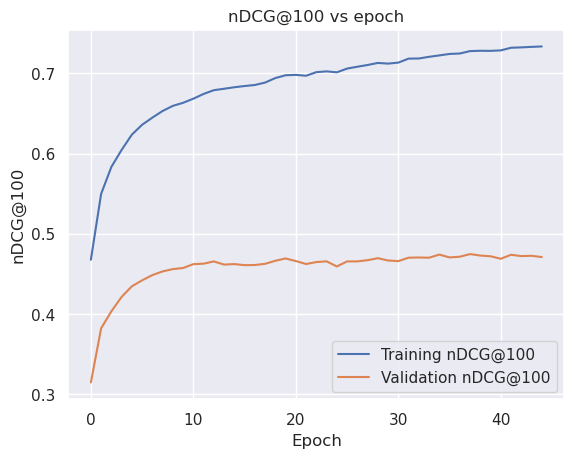

In [28]:
epochs = range(0, 45)
#loss_score = [each.cpu().data.numpy().argmax() for each in loss_score]
# term=1
# loss_data = []
# while term<len(loss_score):   # if the array length is 6 then it will have upto element 5.
#     loss_data.append(loss_score[term])
#     term=term+947 
plt.plot(epochs, train_scores, label='Training nDCG@100')
plt.plot(epochs, valid_scores, label='Validation nDCG@100')

plt.title('nDCG@100 vs epoch')
plt.xlabel('Epoch')
plt.ylabel('nDCG@100')
plt.legend()
plt.savefig('ml20_ndcg_15.png')
plt.show()

In [ ]:
# def predict(self, interaction):
#         user = interaction[self.USER_ID]
#         item = interaction[self.ITEM_ID]

#         rating_matrix = self.get_rating_matrix(user)

#         scores, _, _, _ = self.forward(rating_matrix, self.dropout_prob)

#         return scores[[torch.arange(len(item)).to(self.device), item]]

#     def full_sort_predict(self, interaction):
#         user = interaction[self.USER_ID]

#         rating_matrix = self.get_rating_matrix(user)

#         scores, _, _, _ = self.forward(rating_matrix, self.dropout_prob)

#         return scores.view(-1)

#     def update_prior(self):
#         self.prior.encoder_old.load_state_dict(deepcopy(self.encoder.state_dict()))